In [6]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import powerlaw

In [7]:
filenames = ["result_msr_MSR_fit0_its100000_addprob1_time26_20_13_22.csv",
            "result_reproduce_fit0_its100000_time20_20_10_36.csv"
            "result_no_rec_fit0_its100000_time21_11_16_04.csv",
            "result_delete_state_fit0_its100000_addprob0.8_pref0_time26_21_38_24.csv",
            "result_reproduce_fit0_its100000_addprob1_pref1_time26_21_46_07.csv"]

filenames = [
    "result_msr_MSR_fit0_its100000_addprob1_time26_20_13_22.csv",
            "result_reproduce_fit0_its100000_time20_20_10_36.csv",
            "result_no_rec_fit0_its100000_time21_11_16_04.csv",
            "result_delete_state_fit0_its100000_addprob0.8_pref0_time26_21_38_24.csv",
            "result_reproduce_fit0_its100000_addprob1_pref1_time26_21_46_07.csv",
        "merged_dataframes_pref2.csv",

    "result_reproduce_fit0_its100000_addprob1_pref3_merged.csv"

]

xtick_labels = [
    'with_subclass', 
    'basic_model',
    'no_recursion',
    'delete_statements',
    'caller_pref',
    'calle_pref',
    'no_pref'
]

In [8]:
data = pd.read_csv('commit_sizes/commits_' + filenames[1])
data

,sim,commit,size
0,0,0,2
1,0,1,4
2,0,2,1
3,0,3,0
4,0,4,7
5,0,5,1
6,0,6,1
7,0,7,1
8,0,8,3
9,0,9,1


In [9]:
def load_pickles(filenames):
    dicts = []
    for file_name in filenames:
        data = pd.read_csv('commit_sizes/' + filename)
        
        xmin, gamma, significances = fit_powerlaw(data)
        
from scipy.optimize import curve_fit
import random
from statsmodels.sandbox.stats.multicomp import multipletests


def func_powerlaw(x, a, c, c0):
    return c0 + x**a * c


def boostrapped_distr(data, sample_size, N):
    """
    Create bootstrapped distribution
    """
    gammas = []
    xmins = []
    for i in range(N):
        # Create synthetic data
        data_synt = random.choices(data['size'].values, k=sample_size)
        
        # Get fit results
        results = powerlaw.Fit(data_synt)
        gammas.append(results.power_law.alpha)
        xmins.append(results.power_law.xmin)    
        
    gammas = sorted(gammas)
    xmins = sorted(xmins)
    return gammas, xmins


def find_p_value(value, distr):
    """
    Returns proportion values smaller than value in the distribution"""
    s = 0
    for x in distr:
        if x >= value:
            break
        s += 1
        
    p_value = s/len(distr)
    if p_value <.5:
        return p_value
    else:
        return 1-p_value
    

def fit_powerlaw(data, N_boot):
    # Mean sample size
    sample_size = int(np.array([len(data[data['sim']==sim]) for sim in data['sim'].unique()]).mean())

    # Create bootstrapped distribution for gamma and for MSE
    gamma_distr, xmins_distr = boostrapped_distr(data, sample_size, N_boot)
    MSE_distr = xmins_distr
    
    # Get gamma and MSE for the real simulations
    gammas = []
    xmins = []
    MSEs = []
    
    for sim in data['sim'].unique():        
        # Get gamma and MSE
        results = powerlaw.Fit(data['size'][data['sim']==sim].values)
        gammas.append(results.power_law.alpha)
        xmins.append(results.power_law.xmin)

    return gammas, gamma_distr, MSEs, MSE_distr
    
    
    
def get_data(filenames, labels):
    distrs = {}
    names = []
    for i in range(len(filenames)):
        data = pd.read_csv('commit_sizes/commits_' + filenames[i])
        
        gammas, gamma_distr, MSEs, MSE_distr = fit_powerlaw(data, 60)
        print(labels[i])
        distrs[labels[i]+'gamma'] = gammas
        distrs[labels[i]+'gamma_distr'] = gamma_distr
#         distrs[labels[i]+'MSE'] = MSEs
#         distrs[labels[i]+'MSE_distr'] = MSE_distr
        
        names += [labels[i]+'gamma'
                  , labels[i]+'gamma_distr']
#                   , labels[i]+'MSE', labels[i]+'MSE_distr']
    return distrs, names
        
# fit_powerlaw(data, 10**1)  

def get_means(results):
    means = {}
    for result in results:
        means[result] = np.array(results[result]).mean()
    return means


import scipy.stats as stats
def ANOVA(filenames, labels):
    results, names = get_data(filenames, xtick_labels)
    print(stats.f_oneway(*[results[name] for name in names]))
    means = get_means(results)
    print(means)
    return results, names
    
    
# def t_tests()

In [13]:
results, names = ANOVA(filenames, xtick_labels)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

with
subclass


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

basic
model


Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

no
recursion


Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

delete
state
ments


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

caller
pref


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

callee
pref


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best

no
pref
F_onewayResult(statistic=1.574988140922364, pvalue=0.08659153727314965)
{'with\nsubclassgamma': 1.6621440582015758, 'with\nsubclassgamma_distr': 1.6607233936710057, 'basic\nmodelgamma': 1.660549077648692, 'basic\nmodelgamma_distr': 1.6651071738104215, 'no\nrecursiongamma': 1.6583216337128126, 'no\nrecursiongamma_distr': 1.6830094024272215, 'delete\nstate\nmentsgamma': 1.6652325956001601, 'delete\nstate\nmentsgamma_distr': 1.6663728939462705, 'caller\nprefgamma': 1.6783351334725038, 'caller\nprefgamma_distr': 1.6807273849800082, 'callee\nprefgamma': 1.670096434037983, 'callee\nprefgamma_distr': 1.6838071363800455, 'no\nprefgamma': 1.6707594833901784, 'no\nprefgamma_distr': 1.7025647232680534}



Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating bes

In [14]:
results, names

({'with\nsubclassgamma': [1.6408818154039009,
   1.599128310603274,
   1.61337397889057,
   1.6319169700181406,
   1.8276221515508357,
   1.7172337634473775,
   1.6236609284615193,
   1.6302137862185138,
   1.6810973178803028,
   1.7089847887266312,
   1.6515057318165938,
   1.6942121826859753,
   1.599779532247445,
   1.6055634804494674,
   1.666938656570122,
   1.6490084545094006,
   1.7751440232724685,
   1.6136681196456781,
   1.666030615508466,
   1.5968548199987973,
   1.669122598853368,
   1.6815911814390487,
   1.6271704924216617,
   1.700248366032306,
   1.720757931715918,
   1.6043812985174957,
   1.6619347634018782,
   1.7114778687249408,
   1.6743521538818344,
   1.6285757732674717,
   1.7784941553051214,
   1.6500951022574457,
   1.6392229510875156,
   1.6243809620598944,
   1.6526690632237022,
   1.669228273178174,
   1.630539075044723,
   1.7117237173471658,
   1.6346269326607394,
   1.5804045556339847,
   1.6637642021148435,
   1.6655605313896502,
   1.6961237476473254,

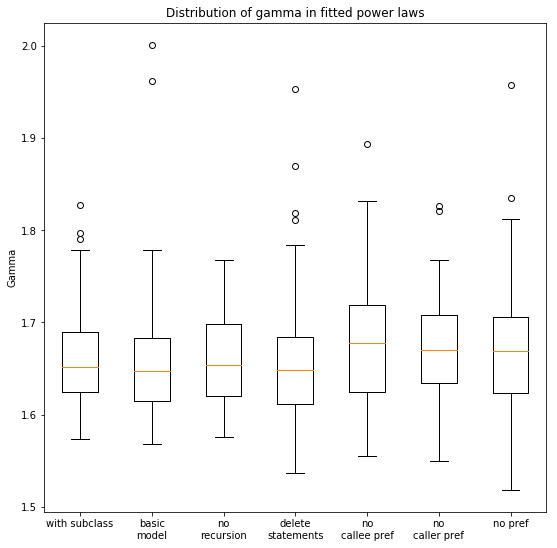

In [26]:
# names = ['with_subclassgamma',
#   'basic_modelgamma',
#   'no_recursiongamma',
#   'delete_statementsgamma',
#   'caller_prefgamma',
#   'calle_prefgamma',
#         'no_prefgamma']

xtick_labels = [
    'with\nsubclass', 
    'basic\nmodel',
    'no\nrecursion',
    'delete\nstate\nments',
    'caller\npref',
    'callee\npref',
    'no\npref'
]


# Get data
plot_data = []
for name in [name+'gamma' for name in xtick_labels]:
    plot_data.append(np.array(results[name]))
    
# Plot data
fig = plt.figure(figsize=(9, 9))
xtick_labels = [
    'with subclass', 
    'basic\nmodel',
    'no\nrecursion',
    'delete\nstatements',
    'no\ncallee pref',
    'no\ncaller pref',
    'no pref'
]
plt.boxplot(plot_data)
plt.xticks(range(1, len(xtick_labels)+1),xtick_labels)
plt.title('Distribution of gamma in fitted power laws')

plt.ylabel('Gamma')
plt.savefig('gammas.png')

In [55]:
def load_pickles(filenames):
    dicts = []
    for filename in filenames:
        data = pd.read_csv(filename)
        data = data[data['sim']==1]
        plot_fmin(data, filename)
        print('one is done')
#         plt.show()

def plot_fmin(data, filename):
    f0=.5
    data_commits = data[data['fmin'] >= f0]
    commits = list(data_commits['step'])
    print(len(commits))
    for commit in commits:
        plt.axvline(commit, alpha=.01, linestyle='-.', c='green')
    
    plt.plot(data['fmean'], label='fmean')
    plt.plot(data['fmean']+data['fstd'], c='orange', alpha=.3, label='std')
    plt.plot(data['fmean']-data['fstd'], c='orange', alpha=.3)
    plt.plot(data['fmin'], c='green', alpha=.3, label='min/max')
    plt.plot(data['fmax'], c='green', alpha=.3, label='')
    plt.title(filename)
    plt.show()

In [ ]:
load_pickles(filenames)

In [36]:
def plot_stats(data_stats):
    fig = plt.figure()
    plt.plot(data_stats['fmean'], label='fmean')
    plt.plot(data_stats['fmean']+data_stats['fstd'], c='orange', alpha=.3, label='std')
    plt.plot(data_stats['fmean']-data_stats['fstd'], c='orange', alpha=.3)
    plt.plot(data_stats['fmin'], c='green', alpha=.3, label='min/max')
    plt.plot(data_stats['fmax'], c='green', alpha=.3, label='')

    plt.title('Mean fitness of all methods')
    plt.xlabel('Time')
    plt.ylabel('Fitness')
    plt.legend()
#     return fig
    plt.show()



#     plt.plot(data_stats['fnum'])
#     plt.ylabel('Number of methods')
#     plt.xlabel('Time')
#     plt.title('Number of methods over time')